In [1]:
# kaggle house price

In [2]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import numpy as np
import pandas as pd

In [3]:
train_data = pd.read_csv('F:/Downloads/train.csv')
test_data = pd.read_csv('F:/Downloads/test.csv')

In [4]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [5]:
# 连续值的预处理 将连续数值的特征进行标准化 缺失的特征用均值代替
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [6]:
# 离散特征转换为 指示特征 缺失值也作为合法特征
all_features = pd.get_dummies(all_features, dummy_na=True)

In [7]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

In [8]:
# 训练模型
loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(200, activation='relu'),
            nn.Dropout(0.32),
            nn.Dense(1))
    net.initialize(init=init.Xavier())

    return net

In [9]:
def log_rmse(net, features, labels):
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    
    return rmse.asscalar()

In [10]:
def train(net, train_features, train_labels, test_featues, test_labels, 
            num_epochs, lr, wd, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)

    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': lr, 'wd': wd
    })

    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)

        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_featues, test_labels))

    return train_ls, test_ls

In [11]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]

        if j == i:
            X_vaild, y_valid = X_part, y_part
        # 这里是组装所选取的验证集之外的k-1折形成训练集
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)

    return X_train, y_train, X_vaild, y_valid


In [12]:
# 训练k次
def k_fold(k, X_train, y_train, num_epochs, lr, wd, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        # 这个里面会 训练出 k个net ?
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, lr, wd, batch_size)

        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        # 这里应该是选择了其中训练的一折来作图
        if 0 == i:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
            range(1, num_epochs + 1), valid_ls, ['train', 'valid'])
        
        print('fold %d, train rmse %f, valid rmse %f' %
                (i, train_ls[-1], valid_ls[-1]))

    return train_l_sum / k, valid_l_sum / k

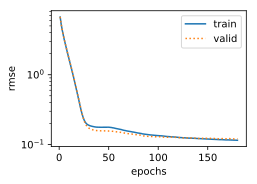

fold 0, train rmse 0.115237, valid rmse 0.120934
fold 1, train rmse 0.105294, valid rmse 0.146806
fold 2, train rmse 0.114341, valid rmse 0.112568
fold 3, train rmse 0.107770, valid rmse 0.141608
4-fold validation: avg train rmse 0.110660, avg valid rmse 0.130479


In [20]:
k, num_epochs, lr, wd, batch_size = 4, 180, 0.01, 65, 64 # this is my best
# k, num_epochs, lr, wd, batch_size = 5, 50, 0.05, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, wd, batch_size)

print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

In [14]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr,
                        wd, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, 
                            num_epochs, lr, wd, batch_size)
    d2l.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape((1, -1))[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('sub.csv', index=False)

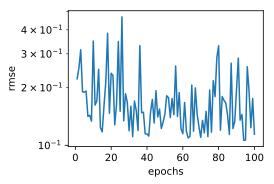

train rmse 0.114295


In [15]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, wd,
batch_size)

In [16]:
# help(pd.get_dummies)